In [1]:
# Import necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split
import torch

In [4]:
# Load data and set up device

data = pd.read_csv('./data/edos-labelled-annotations.csv')
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [7]:
# Filter data to include only sexist texts and map vector labels to numerical values

sexist_data = data[data['label_sexist'] == 'sexist']

# Create a mapping for vector labels
unique_labels = sexist_data['label_vector'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Extract text and labels, and map labels to numerical values
text = list(sexist_data['text'])
labels = sexist_data['label_vector'].map(label_mapping).values
labels = torch.tensor(labels, dtype=torch.long)

In [8]:
# Split data into training, validation, and test sets

train_text, temp_text, train_labels, temp_labels = train_test_split(text, labels, test_size=0.8, random_state=42)
valid_text, test_text, valid_labels, test_labels = train_test_split(temp_text, temp_labels, test_size=0.5, random_state=42)

In [9]:
#  Load RoBERTa tokenizer and model

from transformers import AutoTokenizer, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_mapping))

# Move model to the appropriate device (GPU, MPS, or CPU)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Tokenize the data

tokenized_train = tokenizer(train_text, truncation=True, padding=True, return_tensors="pt")
tokenized_valid = tokenizer(valid_text, truncation=True, padding=True, return_tensors="pt")
tokenized_test = tokenizer(test_text, truncation=True, padding=True, return_tensors="pt")

In [11]:
# Define a custom dataset class

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, device):
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], device=self.device)
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances for training, validation, and testing
train_data = CustomDataset(tokenized_train, train_labels, device)
valid_data = CustomDataset(tokenized_valid, valid_labels, device)
test_data = CustomDataset(tokenized_test, test_labels, device)


In [12]:
# Create data loaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [13]:
# Train the model

from tqdm import tqdm
import torch

epochs = 5
learning_rate = 1e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    num_batches_train = 0

    batch_progress = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs} Training', leave=False)

    for batch in batch_progress:
        inputs = {key: value.to(device) if key != 'labels' else value for key, value in batch.items()}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        num_batches_train += 1
        batch_progress.set_postfix(loss=f'{total_train_loss / num_batches_train:.4f}')

    average_train_loss = total_train_loss / num_batches_train

    total_validation_loss = 0
    num_batches_validation = 0
    model.eval()

    for batch in valid_dataloader:
        with torch.no_grad():
            inputs = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss

            total_validation_loss += loss.item()
            num_batches_validation += 1

    average_validation_loss = total_validation_loss / num_batches_validation

    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {average_train_loss:.4f}, Val Loss: {average_validation_loss:.4f}')

    scheduler.step()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/5 Training:   0%|          | 0/384 [00:00<?, ?it/s]/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_5760/2187453862.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_5760/2187453862.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rathe

Epoch 1/5 - Train Loss: 2.0222, Val Loss: 1.7524


Epoch 2/5 - Train Loss: 1.6767, Val Loss: 1.6109


Epoch 3/5 - Train Loss: 1.4240, Val Loss: 1.5815


Epoch 4/5 - Train Loss: 1.3824, Val Loss: 1.5824


Epoch 5/5 - Train Loss: 1.3410, Val Loss: 1.5779


Testing:   0%|          | 0/767 [00:00<?, ?it/s]/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_5760/2187453862.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device=self.device) for key, val in self.encodings.items()}
/var/folders/pp/f9mc48911vs717rh_h3szgx80000gn/T/ipykernel_5760/2187453862.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], device=self.device)


Test Loss: 1.5639
Accuracy: 0.4477


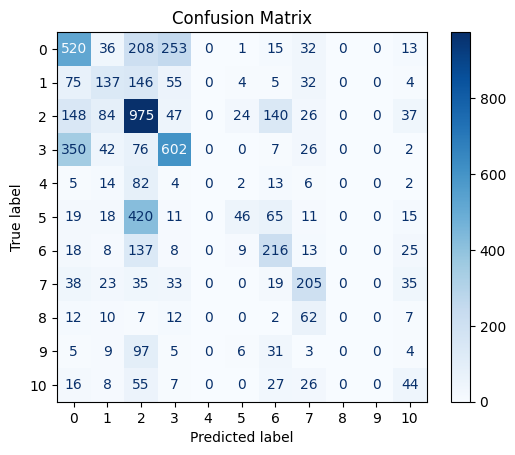

In [14]:
# Test the model and evaluate performance

import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

model.eval()

total_test_loss = 0
num_batches_test = 0

test_progress_bar = tqdm(test_dataloader, desc=f'Testing', leave=False)

for batch in test_progress_bar:
    with torch.no_grad():
        inputs = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss

        total_test_loss += loss.item()
        num_batches_test += 1

        true_labels.extend(batch['labels'].cpu().numpy())
        predicted_labels.extend(outputs.logits.argmax(dim=1).cpu().numpy())

average_test_loss = total_test_loss / num_batches_test
test_progress_bar.set_postfix({'test_loss': average_test_loss}, refresh=True)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Test Loss: {average_test_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Save the model and tokenizer
save_directory = "./roberta-model-c"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./roberta-model-c/tokenizer_config.json',
 './roberta-model-c/special_tokens_map.json',
 './roberta-model-c/vocab.json',
 './roberta-model-c/merges.txt',
 './roberta-model-c/added_tokens.json',
 './roberta-model-c/tokenizer.json')

In [16]:
print(label_mapping)

{'2.2 aggressive and emotive attacks': 0, '2.3 dehumanising attacks & overt sexual objectification': 1, '2.1 descriptive attacks': 2, '3.1 casual use of gendered slurs, profanities, and insults': 3, '3.3 backhanded gendered compliments': 4, '3.2 immutable gender differences and gender stereotypes': 5, '4.2 supporting systemic discrimination against women as a group': 6, '1.2 incitement and encouragement of harm': 7, '1.1 threats of harm': 8, '3.4 condescending explanations or unwelcome advice': 9, '4.1 supporting mistreatment of individual women': 10}
